In [2]:
import sys
import os

In [3]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from typing import List
import matplotlib.pyplot as plt
import math
import time
sys.path.insert(1, '../utils')
from utils import *
from utils import plot_solution, greedy_2_regret_weighted, score
from typing import Callable
from abc import ABC, abstractmethod
from sortedcontainers import SortedList

In [4]:
a=pd.read_csv('../data/TSPA.csv', sep=';', header=None)
b=pd.read_csv('../data/TSPB.csv', sep=';', header=None)
tspa=pd.DataFrame(data=a.values, columns=['x', 'y', 'val'])
tspb=pd.DataFrame(data=b.values, columns=['x', 'y', 'val'])
coordinates=tspa[['x', 'y']].values
coordinatesb=tspb[['x', 'y']].values
dist=distance_matrix(coordinates, coordinates)
dist=np.round(dist)
distb=distance_matrix(coordinatesb, coordinatesb)
distb=np.round(distb)
costs=tspa[['val']].values
costsb=tspb[['val']].values

In [5]:
def get_random_solution(n: int) -> list[int]:
    a=np.arange(0,n)
    np.random.shuffle(a)

    return list(a[:int(np.ceil(n/2))])

In [6]:
class Neighborhood(ABC):
    @abstractmethod
    def neighborhood_size(self):
        pass

    @abstractmethod
    def get_difference(self, ind, solution: List[int], unselected):
        pass

    @abstractmethod
    def modify_solution(self, ind, solution: List[int], unselected):
        pass


In [7]:
class NodeNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.dist_mat = (distance_matrix+costs).T
        self.indexes = list()
        for i in range(n-1):
            for j in range(i+1, n):
                self.indexes.append((i,j))

    def neighborhood_size(self):
        return len(self.indexes)
    
    def get_difference(self, ind, solution: List[int], unselected):
        n = len(solution)
        i, j = self.indexes[ind]
        i1 = solution[(i-1)%n]
        i2 = solution[i]
        i3 = solution[(i+1)%n]

        j1 = solution[(j-1)%n]
        j2 = solution[j%n]
        j3 = solution[(j+1)%n]
        #edge case when two consecutive nodes selected
        if i-j == -1:
            return -self.dist_mat[i1, i2] - self.dist_mat[i2, j2] - self.dist_mat[j2, j3] \
                + self.dist_mat[i1, j2] + self.dist_mat[j2, i2] + self.dist_mat[i2, j3]
        
        if i == 0 and j == n - 1:
            return -self.dist_mat[j1, j2] - self.dist_mat[j2, i2] - self.dist_mat[i2, i3] \
                + self.dist_mat[j1, i2] + self.dist_mat[i2, j2] + self.dist_mat[j2, i3]
        
        difference = -self.dist_mat[i1, i2] - self.dist_mat[i2, i3] - self.dist_mat[j1, j2] - self.dist_mat[j2, j3] \
            + self.dist_mat[i1, j2] + self.dist_mat[j2, i3] + self.dist_mat[j1, i2] + self.dist_mat[i2, j3]
        return difference
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        solution[i], solution[j] = solution[j], solution[i]
        return solution

In [8]:
class EdgeNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.distance_matrix = distance_matrix
        self.costs = costs
        self.indexes = list()
        for i in range(1, n-1):
            m = n - 1 if i == 1 else n
            for j in range(i+1, m):
                self.indexes.append((i,j))

    def neighborhood_size(self):
        return len(self.indexes)
    
    def get_difference(self, ind, solution: List[int], unselected: SortedList):
        n = len(solution)
        i, j = self.indexes[ind]

        i1 = solution[i - 1]
        i2 = solution[i]

        j1 = solution[j]
        j2 = solution[(j + 1)%n]

        return -self.distance_matrix[i1, i2] - self.distance_matrix[j1, j2] \
            + self.distance_matrix[i1, j1] + self.distance_matrix[i2, j2]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        solution[i:j+1] = solution[j:i-1:-1]
        return solution


In [9]:
from typing import List


class InterNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.dist_mat = (distance_matrix+costs).T
        self.indexes = list()
        m = len(self.dist_mat) - n
        for i in range(n):
            for j in range(m):
                self.indexes.append((i,j))

    def neighborhood_size(self):
        return len(self.indexes)
    
    def get_difference(self, ind, solution: List[int], unselected):
        n = len(solution)
        i, j = self.indexes[ind]
        i1 = solution[(i-1)%n]
        i2 = solution[i]
        i3 = solution[(i+1)%n]

        j1 = unselected[j]

        return -self.dist_mat[i1, i2] -self.dist_mat[i2, i3] + self.dist_mat[i1, j1] + self.dist_mat[j1, i3]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        current_node = solution[i]
        solution[i] = unselected[j]
        unselected.remove(unselected[j])
        unselected.add(current_node)
        return solution

In [10]:
class CombinedNeighborhood(Neighborhood):
    def __init__(self , neighborhoods: List[Neighborhood]) -> None:
        self.neighborhoods = neighborhoods
        self.size = sum(n.neighborhood_size() for n in self.neighborhoods)

    def neighborhood_size(self):
        return self.size
    
    def get_difference(self, ind, solution: List[int], unselected):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.get_difference(ind, solution, unselected)
            ind -= size

    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.modify_solution(ind, solution, unselected)
            ind -= size

In [11]:
test_n = 100
test_distances = np.random.randint(0, 100, (test_n, test_n))
test_costs = np.random.randint(0, 100, (test_n, 1))
test_solution = get_random_solution(test_n)
for i in range(test_n):
    for j in range(test_n):
        if i == j:
            test_distances[i, j]=0
        else:
            test_distances[i, j] = test_distances[j, i]

test_unselected = SortedList(range(test_n))
for i in test_solution:
    test_unselected.remove(i)

print(test_distances)
print(test_costs)
print(test_solution)

[[ 0 34 64 ...  7 78 82]
 [34  0 37 ... 48 73 17]
 [64 37  0 ... 14 35 55]
 ...
 [ 7 48 14 ...  0 39 72]
 [78 73 35 ... 39  0 53]
 [82 17 55 ... 72 53  0]]
[[94]
 [73]
 [73]
 [83]
 [63]
 [63]
 [27]
 [81]
 [49]
 [85]
 [ 0]
 [76]
 [46]
 [48]
 [40]
 [39]
 [57]
 [38]
 [42]
 [91]
 [32]
 [46]
 [28]
 [67]
 [ 1]
 [14]
 [88]
 [61]
 [20]
 [23]
 [83]
 [ 0]
 [86]
 [ 8]
 [19]
 [21]
 [95]
 [10]
 [89]
 [77]
 [91]
 [44]
 [ 0]
 [79]
 [85]
 [19]
 [19]
 [83]
 [40]
 [ 0]
 [ 8]
 [28]
 [ 3]
 [70]
 [ 0]
 [76]
 [92]
 [74]
 [37]
 [ 3]
 [23]
 [94]
 [ 8]
 [36]
 [ 5]
 [23]
 [56]
 [74]
 [43]
 [65]
 [29]
 [49]
 [34]
 [32]
 [43]
 [22]
 [74]
 [92]
 [74]
 [81]
 [14]
 [ 1]
 [19]
 [ 1]
 [71]
 [86]
 [98]
 [91]
 [41]
 [81]
 [41]
 [ 7]
 [71]
 [20]
 [65]
 [ 7]
 [54]
 [ 4]
 [46]
 [47]]
[np.int64(12), np.int64(73), np.int64(20), np.int64(11), np.int64(14), np.int64(76), np.int64(85), np.int64(94), np.int64(3), np.int64(89), np.int64(54), np.int64(23), np.int64(93), np.int64(32), np.int64(48), np.int64(91), np.int64(52), np.in

In [12]:
def test_neighborhoods(test_solution, test_distances, test_costs, test_neighborhood):
    test_score = score(test_solution, test_distances, test_costs)

    test_objective_changes = [test_neighborhood.get_difference(i, test_solution, test_unselected)
                                for i in range(test_neighborhood.neighborhood_size())]

    test_new_solutions = [test_neighborhood.modify_solution(i, test_solution.copy(), test_unselected.copy())
                                for i in range(test_neighborhood.neighborhood_size())]

    test_scores = [score(solution, test_distances, test_costs) for solution in test_new_solutions]
    test_score_changes = [-test_score + score for score in test_scores]
    for i, j in zip(test_objective_changes, test_score_changes):
        assert i == j

In [13]:
test_neighborhoods(
    test_solution, 
    test_distances, 
    test_costs, 
    NodeNeighborhood(test_distances, test_costs, test_n // 2), 
    )

test_neighborhoods(
    test_solution, 
    test_distances, 
    test_costs, 
    EdgeNeighborhood(test_distances, test_costs, test_n // 2), 
    )

test_neighborhoods(
    test_solution, 
    test_distances, 
    test_costs, 
    InterNeighborhood(test_distances, test_costs, test_n // 2), 
    )

In [14]:
def steepest(starting_solution: List[int], distance_matrix: np.ndarray, costs: np.ndarray, neighborhood: Neighborhood) -> list:
    unselected = SortedList(range(len(costs)))
    for i in starting_solution:
        unselected.remove(i)
    solution = starting_solution.copy()
    while True:
        objective_changes = [neighborhood.get_difference(i, solution, unselected)
                            for i in range(neighborhood.neighborhood_size())]
        best_index = np.argmin(objective_changes)
        if objective_changes[best_index] >= 0:
            return solution
        solution = neighborhood.modify_solution(best_index, solution, unselected)


In [15]:
def greedy(starting_solution: List[int], distance_matrix: np.ndarray, costs: np.ndarray, neighborhood: Neighborhood) -> list:
    unselected = SortedList(range(len(costs)))
    for i in starting_solution:
        unselected.remove(i)
    solution = starting_solution.copy()
    while True:
        indexes = np.arange(neighborhood.neighborhood_size())
        np.random.shuffle(indexes)
        objective_change = 1
        for i in indexes:
            objective_change = neighborhood.get_difference(i, solution, unselected)
            if objective_change < 0:
                solution = neighborhood.modify_solution(i, solution, unselected)
                break
        if objective_change >= 0:
            return solution

In [52]:
def test_method(method: Callable, neighborhood: Neighborhood, initial_solutions: list, dist, costs, coordinates, name='',):
    scores_2=[]
    sols_2=[]
    times = list()
    for x in range(200):
        initial_solution = initial_solutions[x].copy()
    
        begin_time = time.time()
        solution_2=method(initial_solution, dist, costs, neighborhood)
        times.append(time.time() - begin_time)

        solution_2 = [int(e) for e in solution_2]
        sols_2.append(solution_2)

        scores_2.append(score(solution_2, dist, costs))   

    print('scores of greedy, random, node neighborhood: ', min(scores_2), sum(scores_2)/len(scores_2), max(scores_2))
    print(sols_2[scores_2.index(min(scores_2))])
    print(f'execution time: {min(times)} {sum(times)/len(times)} {max(times)}')
    plot_solution(sols_2[scores_2.index(min(scores_2))], coordinates, costs, f'best solution for {name}')

In [30]:
random_solutions = [get_random_solution(200) for _ in range(200)]
best_solutions = [greedy_2_regret_weighted(x, dist, costs) for x in range(200)]

In [32]:
n = 200
nodeNeighborhood = NodeNeighborhood(dist, costs, n // 2)
interNeighborhood = InterNeighborhood(dist, costs, n // 2)
edgeNeighborhood = EdgeNeighborhood(dist, costs, n // 2)
neighborhood1 = CombinedNeighborhood([nodeNeighborhood, interNeighborhood])
neighborhood2 = CombinedNeighborhood([edgeNeighborhood, interNeighborhood])


scores of greedy, random, node neighborhood:  78981 86162.46 95652
[143, 183, 144, 138, 185, 40, 119, 165, 90, 81, 196, 113, 175, 171, 16, 44, 75, 86, 101, 1, 2, 120, 78, 31, 145, 92, 129, 57, 55, 52, 106, 178, 3, 14, 49, 102, 62, 9, 148, 167, 152, 97, 26, 100, 63, 80, 176, 51, 118, 5, 42, 43, 149, 131, 160, 184, 35, 127, 70, 154, 180, 53, 94, 124, 186, 89, 23, 137, 123, 112, 4, 177, 54, 34, 181, 193, 159, 146, 22, 18, 69, 108, 140, 93, 117, 170, 0, 46, 116, 65, 162, 135, 79, 133, 151, 59, 115, 41, 139, 68]
execution time: 0.36533141136169434 0.6030091857910156 1.1730601787567139


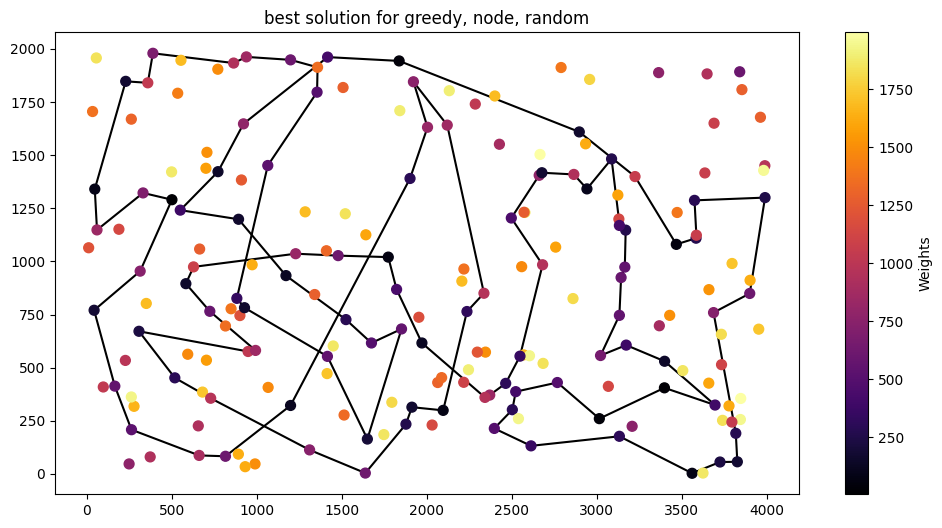

In [38]:
test_method(greedy, neighborhood1, random_solutions,dist, costs, coordinates, 'greedy, node, random')

scores of greedy, random, node neighborhood:  71748 73803.915 78492
[23, 137, 176, 80, 133, 79, 63, 94, 124, 167, 148, 62, 144, 14, 49, 178, 106, 52, 55, 129, 92, 57, 185, 119, 165, 39, 27, 90, 40, 196, 145, 78, 31, 56, 113, 175, 171, 16, 25, 44, 120, 2, 75, 86, 101, 1, 152, 97, 26, 100, 121, 53, 158, 180, 154, 135, 70, 127, 123, 162, 151, 51, 118, 59, 115, 116, 65, 47, 149, 131, 35, 112, 4, 177, 54, 48, 34, 160, 184, 43, 42, 181, 146, 22, 18, 108, 69, 159, 193, 41, 139, 46, 68, 140, 93, 117, 0, 143, 183, 89]
execution time: 0.28425002098083496 0.41483268499374387 0.8177435398101807


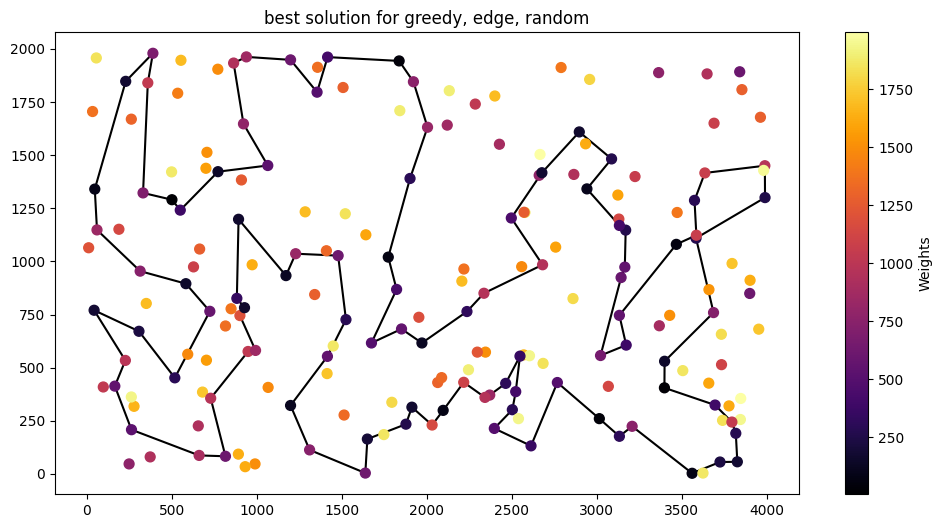

In [39]:
test_method(greedy, neighborhood2, random_solutions, dist, costs, coordinates,'greedy, edge, random')

scores of greedy, random, node neighborhood:  70687 71624.125 72950
[117, 0, 46, 68, 139, 115, 193, 41, 5, 42, 181, 159, 69, 108, 18, 22, 146, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 43, 116, 65, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 121, 100, 26, 86, 75, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 179, 196, 81, 90, 165, 40, 185, 106, 178, 3, 14, 144, 62, 9, 148, 102, 49, 52, 55, 57, 92, 129, 82, 120, 2, 101, 1, 97, 152, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143]
execution time: 0.04403996467590332 0.11790697693824768 0.31429314613342285


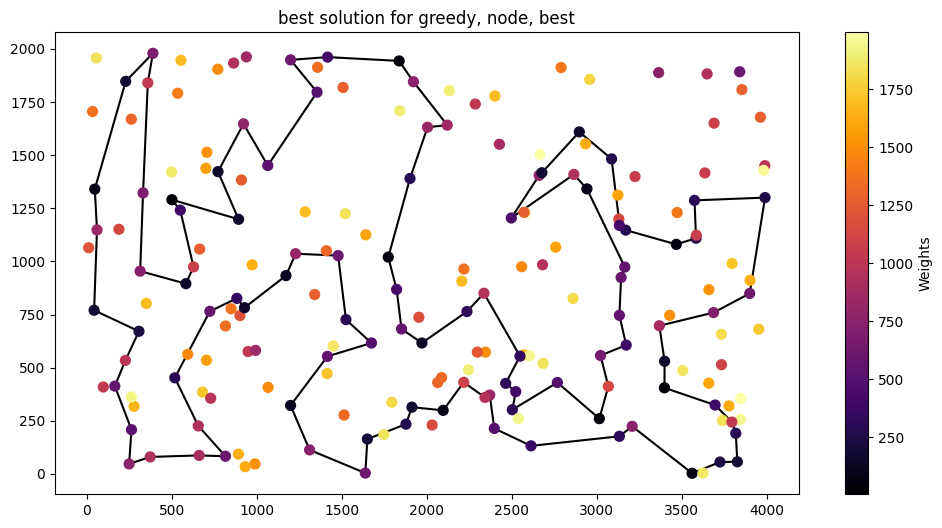

In [40]:
test_method(greedy, neighborhood1, best_solutions, dist, costs, coordinates, 'greedy, node, best')

scores of greedy, random, node neighborhood:  70571 71495.595 72546
[186, 23, 137, 176, 80, 79, 63, 94, 124, 152, 97, 1, 101, 2, 82, 129, 92, 57, 55, 52, 49, 102, 148, 9, 62, 144, 14, 3, 178, 106, 185, 40, 165, 90, 81, 196, 179, 145, 78, 31, 56, 113, 175, 171, 16, 25, 44, 120, 75, 86, 26, 100, 121, 53, 180, 154, 135, 70, 127, 123, 162, 133, 151, 51, 118, 59, 65, 116, 43, 184, 84, 112, 4, 190, 10, 177, 54, 48, 160, 34, 146, 22, 18, 108, 69, 159, 181, 42, 5, 41, 193, 115, 139, 68, 46, 0, 117, 143, 183, 89]
execution time: 0.044042348861694336 0.11054548740386963 0.24523067474365234


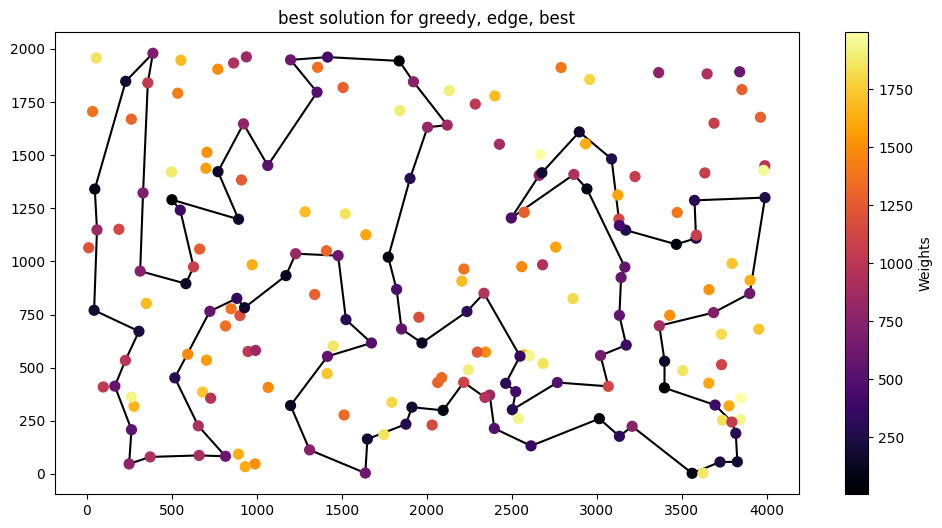

In [41]:
test_method(greedy, neighborhood2, best_solutions,dist, costs, coordinates, 'greedy, edge, best')

scores of greedy, random, node neighborhood:  80166 88013.86 96282
[102, 90, 81, 196, 129, 2, 86, 127, 123, 181, 195, 22, 146, 34, 177, 4, 112, 84, 35, 131, 149, 115, 46, 139, 193, 41, 160, 48, 54, 184, 43, 118, 51, 176, 148, 49, 178, 106, 165, 40, 185, 52, 55, 57, 92, 78, 175, 171, 16, 44, 120, 75, 101, 1, 97, 26, 100, 121, 80, 137, 23, 89, 183, 143, 170, 0, 117, 93, 108, 18, 159, 5, 42, 116, 65, 59, 162, 151, 133, 79, 122, 63, 180, 135, 70, 154, 53, 94, 124, 152, 25, 113, 56, 31, 145, 179, 14, 144, 62, 9]
execution time: 5.053608417510986 6.440235903263092 8.714948654174805


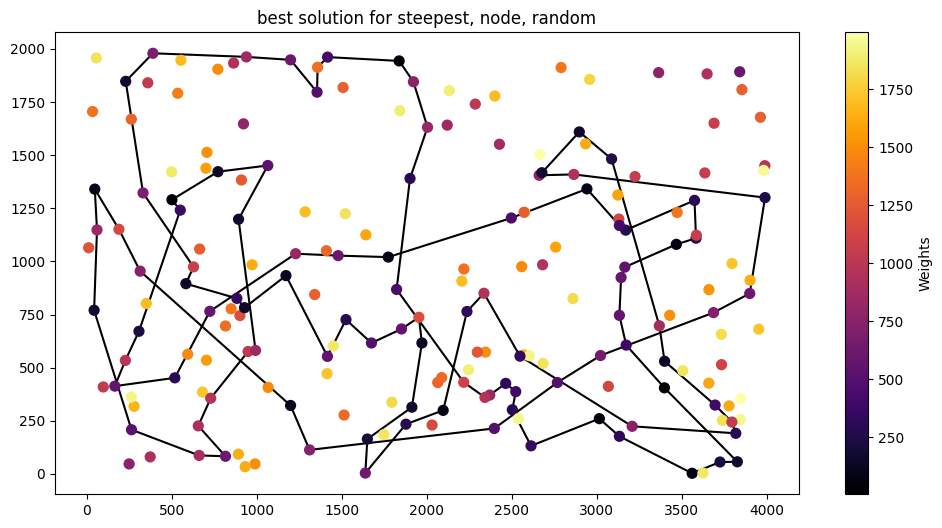

In [42]:
test_method(steepest, neighborhood1, random_solutions,dist, costs, coordinates, 'steepest, node, random')

scores of greedy, random, node neighborhood:  71459 73795.87 77839
[133, 79, 63, 180, 154, 135, 70, 127, 123, 112, 4, 84, 35, 184, 10, 177, 54, 48, 160, 34, 22, 181, 42, 43, 116, 65, 47, 131, 149, 59, 118, 115, 46, 139, 41, 193, 159, 18, 69, 108, 93, 117, 143, 170, 0, 153, 183, 89, 186, 23, 137, 148, 9, 62, 102, 144, 14, 49, 3, 178, 106, 52, 55, 185, 40, 119, 165, 90, 81, 196, 31, 56, 113, 175, 171, 16, 78, 145, 179, 57, 92, 129, 25, 44, 120, 2, 152, 97, 1, 101, 75, 86, 26, 53, 94, 80, 176, 51, 151, 162]
execution time: 3.7953040599823 4.660890556573868 5.480503797531128


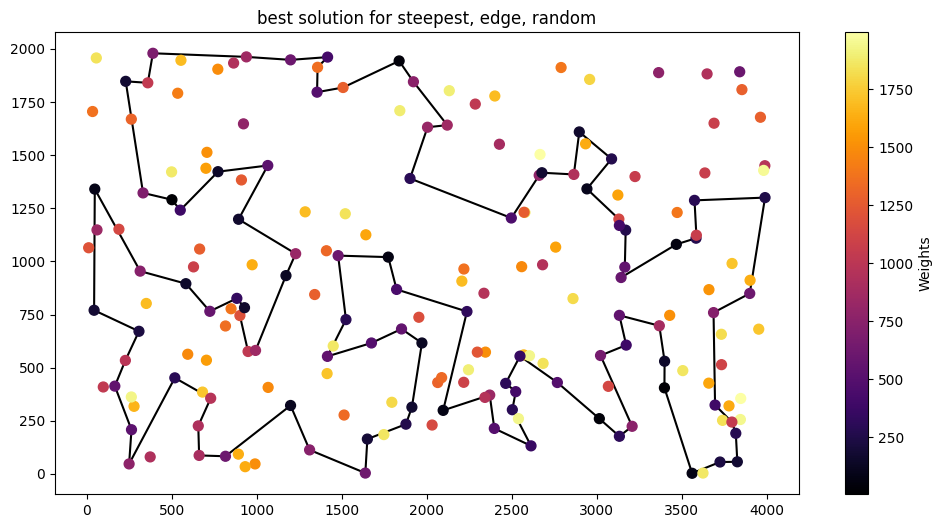

In [43]:
test_method(steepest, neighborhood2, random_solutions, dist, costs, coordinates,'steepest, edge, random')

scores of greedy, random, node neighborhood:  70626 71615.87 72950
[0, 117, 93, 68, 46, 115, 139, 193, 41, 5, 42, 181, 159, 69, 108, 18, 22, 146, 34, 160, 48, 54, 177, 10, 190, 4, 112, 184, 43, 116, 65, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 121, 100, 26, 86, 75, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 179, 196, 81, 90, 165, 40, 185, 106, 178, 3, 14, 144, 62, 9, 148, 102, 49, 52, 55, 57, 92, 129, 82, 120, 2, 101, 1, 97, 152, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143]
execution time: 0.07205653190612793 0.2133494234085083 0.43639683723449707


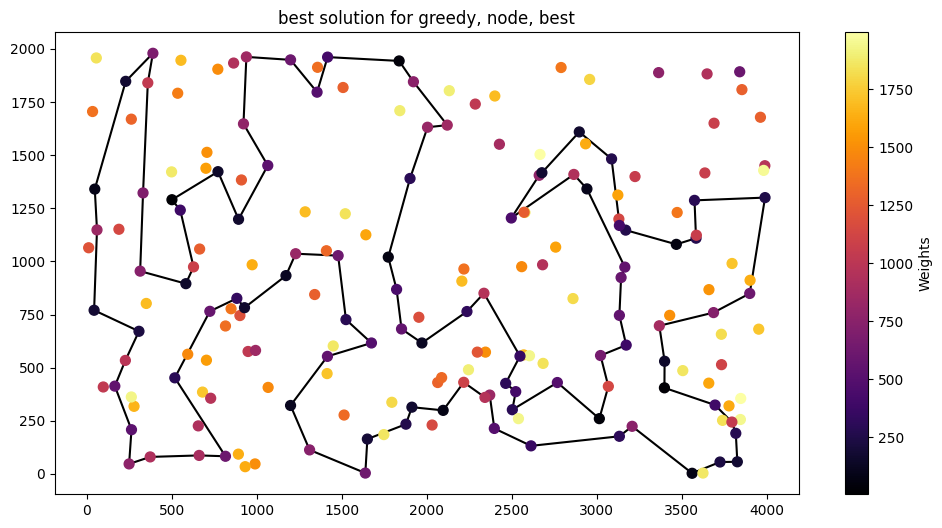

In [44]:
test_method(steepest, neighborhood1, best_solutions,dist, costs, coordinates, 'greedy, node, best')

scores of greedy, random, node neighborhood:  70510 71460.32 72614
[117, 0, 143, 183, 89, 186, 23, 137, 176, 80, 79, 63, 94, 124, 152, 97, 1, 101, 2, 82, 129, 92, 57, 55, 52, 49, 102, 148, 9, 62, 144, 14, 3, 178, 106, 185, 40, 165, 90, 81, 196, 179, 145, 78, 31, 56, 113, 175, 171, 16, 25, 44, 120, 75, 86, 26, 100, 121, 53, 180, 154, 135, 70, 127, 123, 162, 133, 151, 51, 118, 59, 65, 116, 43, 184, 112, 4, 190, 10, 177, 54, 48, 160, 34, 146, 22, 18, 108, 69, 159, 181, 42, 5, 41, 193, 139, 115, 46, 68, 93]
execution time: 0.09008193016052246 0.22235756158828734 0.40236639976501465


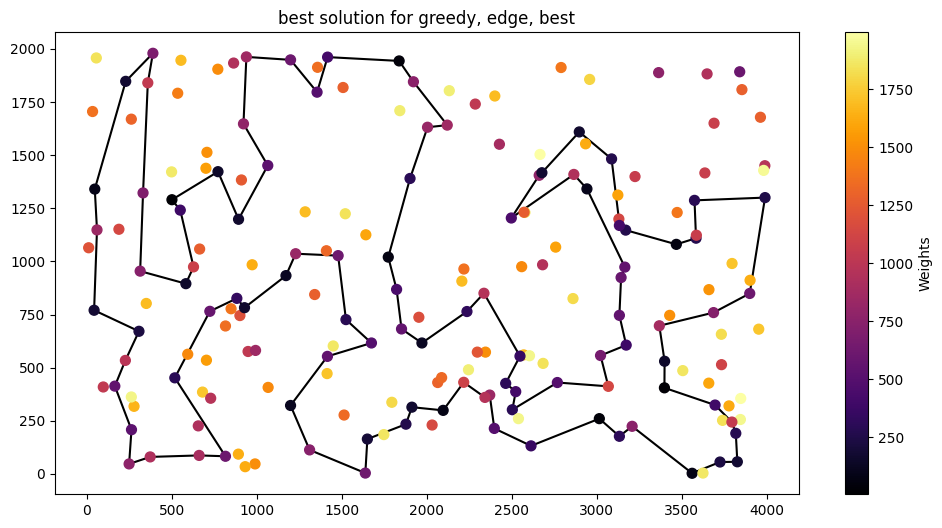

In [45]:
test_method(steepest, neighborhood2, best_solutions,dist, costs, coordinates, 'greedy, edge, best')

In [46]:
n = 200
nodeNeighborhoodb = NodeNeighborhood(distb, costsb, n // 2)
interNeighborhoodb = InterNeighborhood(distb, costsb, n // 2)
edgeNeighborhoodb = EdgeNeighborhood(distb, costsb, n // 2)
neighborhood1b = CombinedNeighborhood([nodeNeighborhoodb, interNeighborhoodb])
neighborhood2b = CombinedNeighborhood([edgeNeighborhoodb, interNeighborhoodb])

scores of greedy, random, node neighborhood:  54306 61188.005 68560
[15, 3, 70, 188, 6, 147, 71, 51, 134, 11, 109, 34, 55, 9, 148, 47, 94, 99, 185, 130, 95, 140, 4, 149, 28, 199, 183, 124, 106, 35, 0, 29, 13, 132, 169, 139, 138, 25, 78, 175, 80, 190, 193, 117, 198, 1, 38, 63, 135, 122, 133, 90, 131, 121, 112, 54, 31, 73, 5, 177, 36, 61, 91, 141, 21, 87, 82, 77, 81, 146, 187, 89, 163, 153, 111, 8, 104, 160, 33, 168, 195, 145, 189, 18, 62, 128, 86, 176, 103, 127, 137, 114, 113, 194, 166, 179, 60, 20, 152, 155]
execution time: 0.3844645023345947 0.6400352621078491 1.1153223514556885


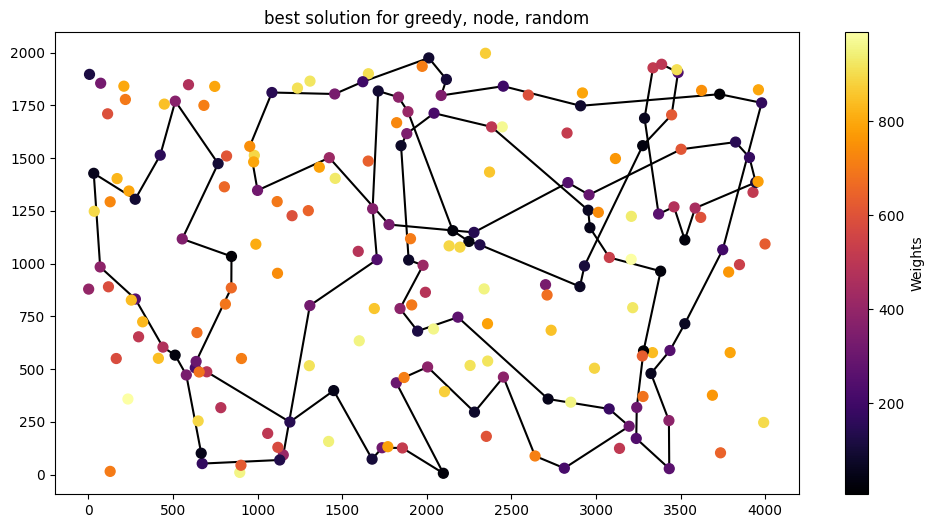

In [53]:
test_method(greedy, neighborhood1b, random_solutions, distb, costsb, coordinatesb,'greedy, node, random')

scores of greedy, random, node neighborhood:  45551 48436.745 51531
[132, 169, 188, 6, 147, 51, 125, 191, 90, 122, 63, 135, 131, 121, 1, 198, 117, 193, 31, 54, 164, 73, 136, 190, 80, 175, 78, 142, 45, 5, 177, 36, 61, 79, 91, 141, 97, 77, 82, 8, 104, 138, 139, 11, 33, 160, 29, 0, 109, 35, 144, 111, 81, 153, 187, 165, 127, 89, 163, 103, 137, 114, 113, 180, 176, 194, 166, 86, 185, 95, 130, 99, 22, 179, 94, 47, 148, 60, 20, 28, 140, 183, 55, 18, 62, 128, 124, 106, 143, 34, 170, 152, 155, 3, 70, 15, 145, 168, 195, 13]
execution time: 0.28727102279663086 0.42174181938171384 0.9584009647369385


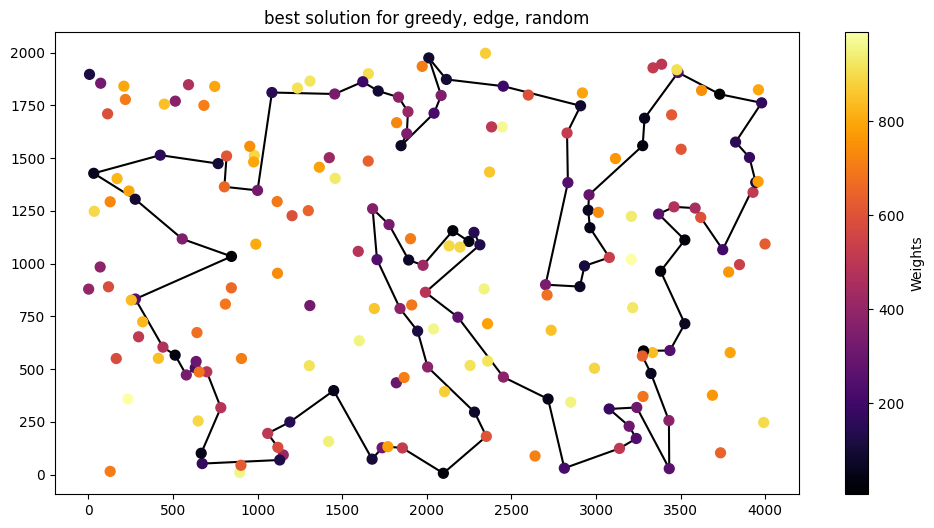

In [54]:
test_method(greedy, neighborhood2b, random_solutions,distb, costsb, coordinatesb, 'greedy, edge, random')

scores of greedy, random, node neighborhood:  53589 60395.9 67322
[183, 140, 28, 149, 4, 152, 184, 155, 3, 70, 15, 145, 168, 139, 11, 138, 177, 5, 78, 175, 45, 80, 190, 136, 25, 118, 51, 121, 73, 54, 31, 193, 117, 198, 156, 24, 1, 131, 134, 195, 13, 132, 169, 188, 6, 147, 122, 63, 135, 90, 29, 143, 124, 62, 94, 47, 148, 60, 20, 55, 18, 34, 35, 109, 0, 160, 33, 144, 56, 104, 8, 21, 61, 36, 141, 111, 106, 128, 86, 179, 172, 166, 194, 113, 103, 163, 153, 81, 77, 187, 165, 89, 127, 114, 176, 185, 22, 99, 130, 95]
execution time: 0.34232020378112793 0.5860983574390412 1.2566394805908203


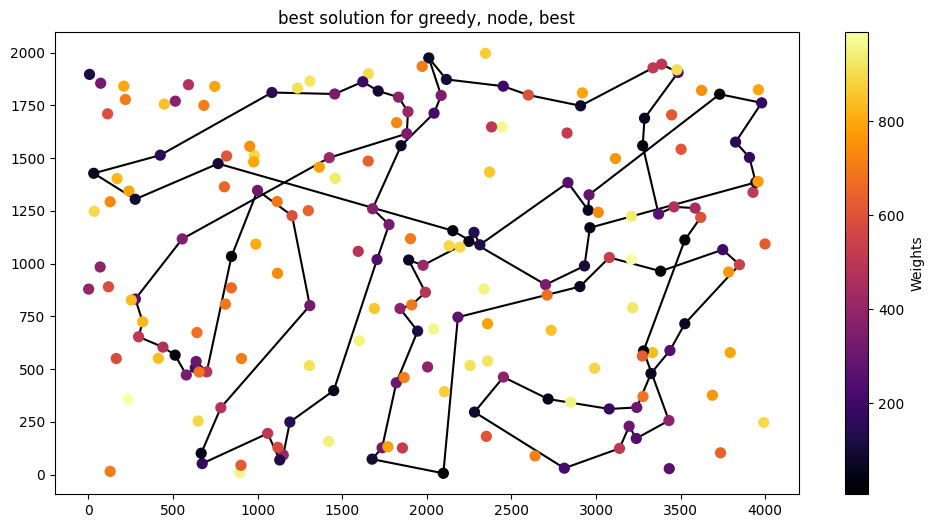

In [55]:
test_method(greedy, neighborhood1b, best_solutions,distb, costsb, coordinatesb, 'greedy, node, best')

scores of greedy, random, node neighborhood:  46087 48069.845 50679
[45, 80, 190, 193, 31, 164, 73, 54, 117, 198, 1, 121, 131, 135, 102, 63, 122, 90, 191, 51, 147, 85, 134, 6, 188, 169, 132, 13, 70, 3, 155, 189, 15, 145, 195, 168, 139, 11, 182, 138, 104, 8, 111, 144, 33, 160, 29, 0, 109, 35, 143, 159, 106, 124, 128, 62, 83, 18, 55, 34, 152, 183, 140, 4, 149, 28, 20, 60, 148, 47, 94, 66, 179, 185, 130, 95, 86, 166, 194, 176, 113, 114, 137, 127, 165, 89, 103, 26, 163, 153, 81, 77, 97, 141, 61, 36, 177, 5, 78, 175]
execution time: 0.28325748443603516 0.4103162455558777 0.7161283493041992


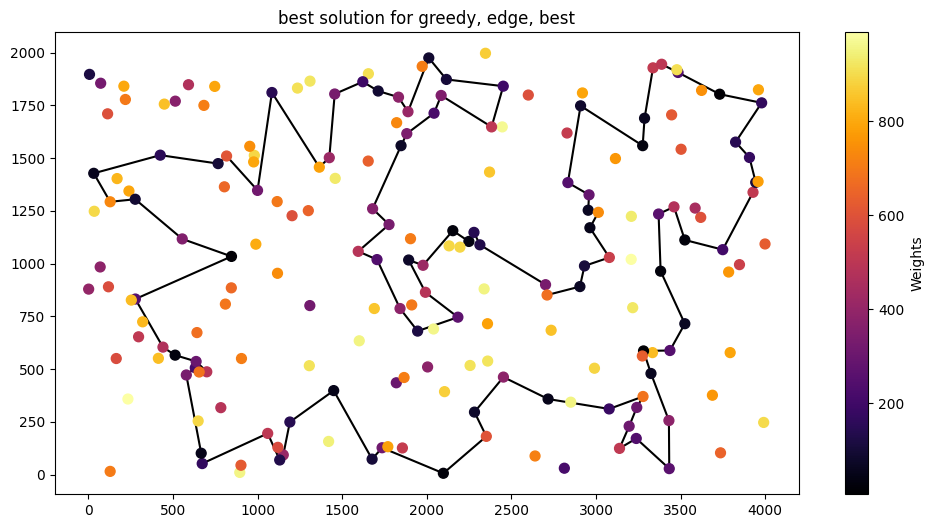

In [56]:
test_method(greedy, neighborhood2b, best_solutions,distb, costsb, coordinatesb, 'greedy, edge, best')

scores of greedy, random, node neighborhood:  55696 63321.38 72274
[107, 40, 63, 135, 193, 136, 190, 80, 175, 78, 142, 45, 5, 177, 36, 61, 141, 77, 153, 187, 163, 89, 127, 103, 113, 128, 62, 18, 55, 95, 185, 86, 159, 111, 144, 160, 29, 0, 109, 34, 152, 140, 183, 124, 106, 143, 35, 51, 90, 191, 147, 134, 74, 118, 121, 131, 38, 27, 1, 156, 198, 117, 31, 54, 25, 182, 139, 43, 195, 145, 15, 3, 70, 161, 188, 6, 169, 132, 13, 168, 11, 104, 8, 21, 87, 82, 81, 180, 176, 194, 166, 179, 94, 47, 148, 20, 33, 138, 122, 133]
execution time: 4.9070281982421875 6.662513267993927 8.386162996292114


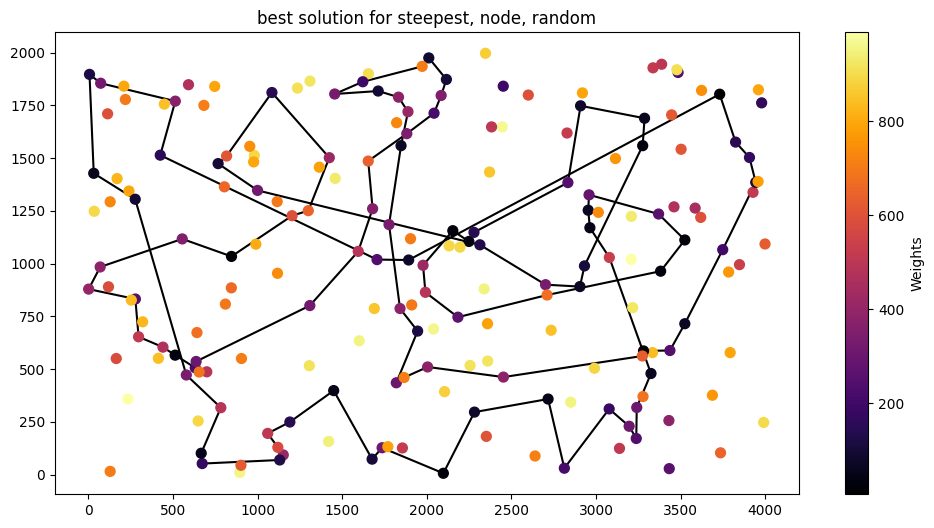

In [57]:
test_method(steepest, neighborhood1b, random_solutions,distb, costsb, coordinatesb, 'steepest, node, random')

scores of greedy, random, node neighborhood:  45904 48274.68 51506
[1, 16, 27, 38, 135, 63, 100, 40, 107, 122, 90, 51, 98, 118, 74, 134, 147, 6, 188, 169, 132, 13, 70, 3, 15, 145, 195, 168, 11, 138, 33, 104, 8, 82, 111, 29, 0, 109, 35, 143, 159, 106, 124, 62, 18, 55, 34, 183, 140, 4, 149, 28, 20, 60, 148, 47, 154, 94, 66, 179, 185, 22, 99, 130, 95, 86, 166, 194, 176, 113, 103, 163, 89, 127, 165, 187, 153, 81, 77, 97, 141, 61, 36, 177, 5, 78, 175, 45, 80, 190, 136, 73, 112, 121, 54, 31, 193, 117, 198, 156]
execution time: 4.170795917510986 4.775455629825592 5.970791816711426


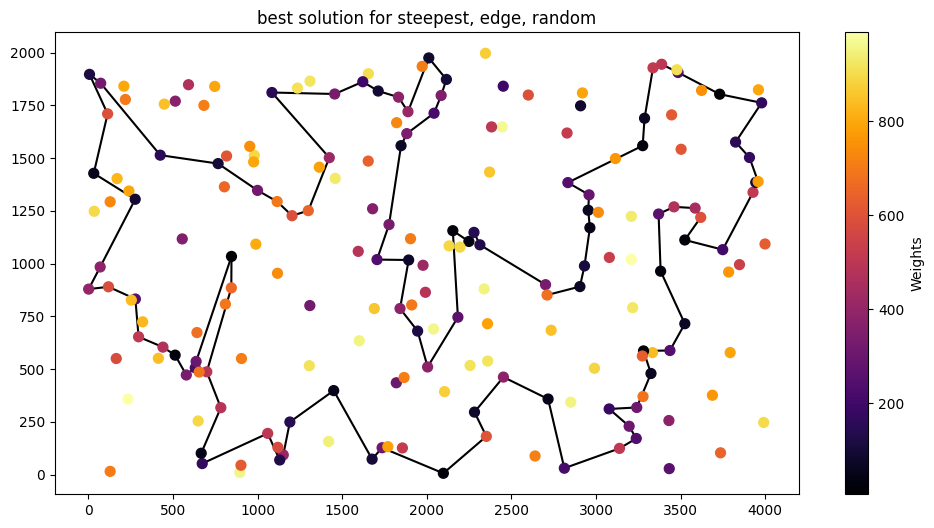

In [58]:
test_method(steepest, neighborhood2b, random_solutions,distb, costsb, coordinatesb, 'steepest, edge, random')

scores of greedy, random, node neighborhood:  57138 64203.09 71808
[70, 3, 15, 145, 195, 168, 11, 33, 160, 29, 0, 170, 140, 183, 83, 128, 124, 41, 111, 104, 8, 153, 176, 194, 114, 137, 127, 89, 163, 103, 26, 113, 180, 106, 159, 81, 77, 97, 91, 61, 21, 87, 82, 86, 185, 130, 95, 35, 109, 34, 55, 18, 62, 143, 144, 138, 182, 118, 51, 90, 107, 40, 63, 135, 1, 198, 117, 193, 190, 80, 175, 78, 5, 177, 36, 141, 187, 166, 179, 94, 47, 148, 20, 28, 149, 152, 155, 121, 54, 31, 131, 122, 133, 10, 147, 6, 188, 169, 132, 13]
execution time: 4.544126987457275 5.824186642169952 7.9472620487213135


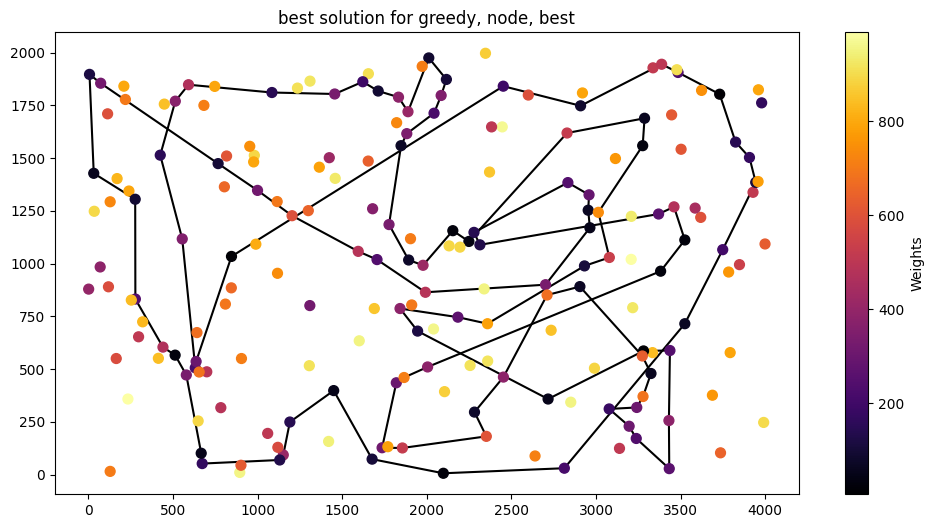

In [59]:
test_method(steepest, neighborhood1b, best_solutions,distb, costsb, coordinatesb, 'greedy, node, best')

scores of greedy, random, node neighborhood:  46012 48204.11 50463
[103, 163, 187, 153, 81, 77, 82, 8, 21, 177, 5, 78, 175, 45, 80, 190, 136, 73, 54, 31, 193, 117, 198, 1, 27, 38, 135, 122, 63, 100, 40, 107, 72, 133, 10, 90, 191, 51, 121, 25, 182, 138, 104, 144, 160, 33, 11, 139, 134, 147, 6, 188, 169, 132, 70, 3, 15, 145, 195, 168, 29, 0, 109, 35, 143, 159, 106, 124, 62, 83, 18, 55, 34, 152, 183, 140, 4, 149, 28, 20, 148, 47, 94, 66, 179, 22, 99, 130, 95, 185, 86, 166, 194, 176, 113, 114, 137, 127, 165, 89]
execution time: 3.687347650527954 4.211193505525589 4.989549398422241


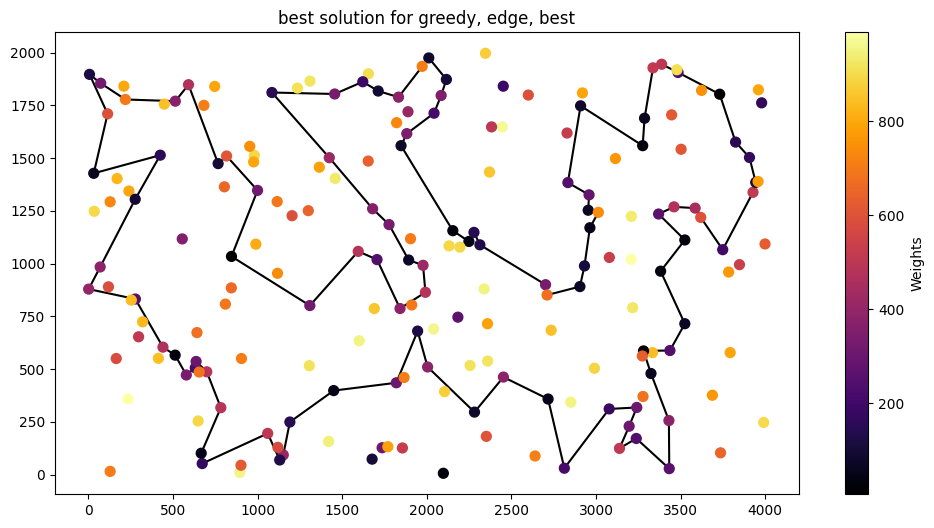

In [60]:
test_method(steepest, neighborhood2b, best_solutions,distb, costsb, coordinatesb, 'greedy, edge, best')